In [2]:
# ISA 530: Final Project
# Quantifying the Predictive Power of Biological vs. Environmental Features in Health Outcomes 
# Longitudinal Analysis 
# Carly Carroll

### Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

### Prepare Data

In [3]:
# paths to data
base_path = "/Users/carlycarroll/Desktop/MIDUS/Data"
long_path = f"{base_path}/MIDUS_twins_long.csv"

# load
long = pd.read_csv(long_path)

# working copy
df = long.copy()

# ensure srh numeric
df["SRH"] = pd.to_numeric(df["SRH"], errors="coerce")

# keep your variable sets
biological    = ["BMI", "HYPERTEN", "DIABETES", "ASTHMA", "DEPRESS"]
environmental = ["EDUC", "HHINCOME", "SMOKING", "ALCOHOL", "EXERCISE", "MARITAL"]

### Longitidinal Regression Model

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  SRH       
No. Observations:  3026     Method:              REML      
No. Groups:        792      Scale:               1.0755    
Min. group size:   2        Log-Likelihood:      -5182.7588
Max. group size:   6        Converged:           Yes       
Mean group size:   3.8                                     
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        7.608    0.042 183.093 0.000  7.526  7.689
C(wave)[T.M2]   -0.079    0.052  -1.533 0.125 -0.181  0.022
C(wave)[T.M3]   -0.181    0.079  -2.285 0.022 -0.337 -0.026
BMI_scaled      -0.311    0.030 -10.358 0.000 -0.369 -0.252
HYPERTEN_scaled  0.121    0.028   4.361 0.000  0.066  0.175
DIABETES_scaled  0.211    0.026   8.015 0.000  0.159  0.262
ASTHMA_scaled    0.147    0.025   5.864 0.000  0.09

,term,estimate,se,ci_low,ci_high
0,Intercept,7.607736,0.041551,7.526297,7.689175
5,DIABETES_scaled,0.210903,0.026315,0.159327,0.262479
6,ASTHMA_scaled,0.146955,0.025059,0.097839,0.196070
7,DEPRESS_scaled,0.127311,0.024187,0.079905,0.174716
4,HYPERTEN_scaled,0.120639,0.027662,0.066422,0.174856
8,EDUC_scaled,0.100394,0.031901,0.037870,0.162918
9,HHINCOME_scaled,0.057056,0.027564,0.003032,0.111081
11,ALCOHOL_scaled,0.039523,0.027414,-0.014207,0.093253
10,SMOKING_scaled,-0.015503,0.022496,-0.059594,0.028589
12,EXERCISE_scaled,-0.052813,0.023391,-0.098659,-0.006967



Variance Components:
Family Variance: 0.224
ID Variance: 0.738
Residual Variance: 1.075

ICC (Shared Family): 0.110
ICC (Family + Individual): 0.472


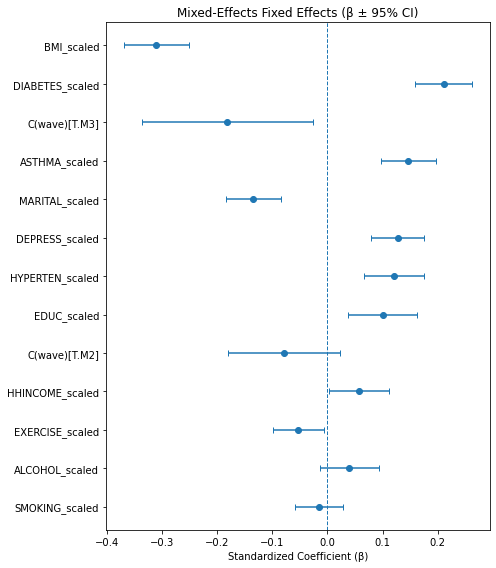

In [4]:
# working copy
df = long.copy()

# ensure SRH is numeric
df["SRH"] = pd.to_numeric(df["SRH"], errors="coerce")

# drop rows missing srh
df = df.dropna(subset=["SRH"]).copy()

# require exactly 2 per family per wave
df = (
    df.groupby(["M2FAMNUM","wave"], group_keys=False)
      .filter(lambda g: g["M2ID"].nunique() == 2)
      .copy()
)

# define predictors: biological + environmental
biological = ["BMI","HYPERTEN","DIABETES","ASTHMA","DEPRESS"]
environmental = ["EDUC","HHINCOME","SMOKING","ALCOHOL","EXERCISE","MARITAL"]
predictors = biological + environmental

# impute missing values with median 
imputer = SimpleImputer(strategy="median")
X_imputer = imputer.fit_transform(df[predictors])

# scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputer)

# attach scaled predictors
for i, c in enumerate(predictors):
    df[c + "_scaled"] = X_scaled[:, i]

# fixed effects formula
fixed = ["C(wave)"] + [c + "_scaled" for c in predictors]
formula = "SRH ~ " + " + ".join(fixed)

# mixed model: random intercepts for family and id
model = MixedLM.from_formula(
    formula=formula,
    groups="M2FAMNUM", # family random intercept
    re_formula="1", # random intercept only
    vc_formula={"id": "0 + C(M2ID)"}, # id random intercept
    data=df
)
result = model.fit(reml=True)
print(result.summary())

# fixed effects table
fe = result.fe_params
fe_se = result.bse.loc[fe.index]
fe_ci = result.conf_int().loc[fe.index]
fe_tab = (
    pd.DataFrame({
        "term": fe.index,
        "estimate": fe.values,
        "se": fe_se.values,
        "ci_low": fe_ci[0].values,
        "ci_high": fe_ci[1].values
    })
    .sort_values("estimate", ascending=False)
)
print("\nFixed Effects Table:")
display(fe_tab.head(12))

# variance components 
txt = result.summary().as_text().splitlines()
var_family = np.nan
var_id     = np.nan
var_resid  = float(result.scale) # residual variance
for line in txt:
    s = line.strip()
    if s.startswith("M2FAMNUM Var"):
        try:
            var_family = float(s.split()[2])  
        except:
            pass
    if s.startswith("id Var"):
        try:
            var_id = float(s.split()[2])
        except:
            pass

# print variance components
print("\nVariance Components:")
print(f"Family Variance: {var_family:.3f}")
print(f"ID Variance: {var_id:.3f}")
print(f"Residual Variance: {var_resid:.3f}")

# icc calculations
den = var_family + var_id + var_resid
icc_family_only = var_family / den
icc_family_plusid = (var_family + var_id) / den
print(f"\nICC (Shared Family): {icc_family_only:.3f}")
print(f"ICC (Family + Individual): {icc_family_plusid:.3f}")

# forest plot
plot_df = fe_tab.copy()
plot_df = plot_df[~plot_df['term'].str.contains('Intercept')].copy()
plot_df = plot_df.reindex(plot_df['estimate'].abs().sort_values(ascending=True).index)
fig, ax = plt.subplots(figsize=(7, 8))
y = range(len(plot_df))
ax.errorbar(plot_df['estimate'], y,
            xerr=[plot_df['estimate']-plot_df['ci_low'], plot_df['ci_high']-plot_df['estimate']],
            fmt='o', capsize=3)
ax.axvline(0, linestyle='--', linewidth=1)
ax.set_yticks(y)
ax.set_yticklabels(plot_df['term'])
ax.set_xlabel('Standardized Coefficient (β)')
ax.set_title('Mixed-Effects Fixed Effects (β ± 95% CI)')
plt.tight_layout()
plt.show()